/Users/gaohuilong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0, 0.5, 'Accuracy')

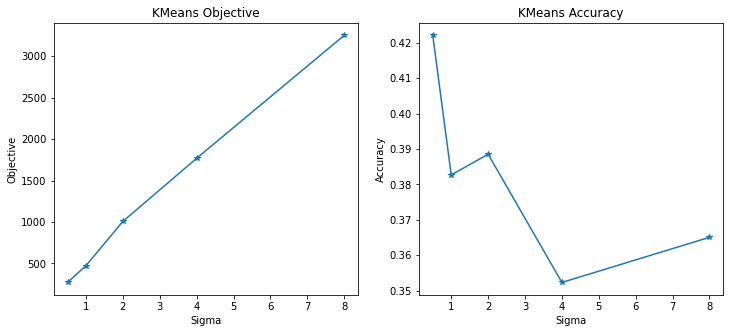

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

p_means = [np.array([-1, -1]), np.array([1, -0.5]), np.array([0, 1])]
p_covs = [np.array([[2, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 2]]), np.array([[1, 0], [0, 2]])]
sigmas = [0.5,1,2,4,8]
all_data = dict()
for sigma in sigmas:
    all_data[sigma] = np.vstack([np.random.multivariate_normal(mu, sigma * cov, 100) for mu, cov in zip(p_means, p_covs)])
kmeans_results = {'Sigma': [], 'Objective': [], 'Accuracy': []}
gmm_results = {'Sigma': [], 'Objective': [], 'Accuracy': []}
rds = 100;
for sigma, data_set in all_data.items():
    kmeans = KMeans(n_clusters=3, random_state=rds).fit(data_set)
    kmeans_results['Sigma'].append(sigma)
    kmeans_results['Objective'].append(kmeans.inertia_)
    kmeans_results['Accuracy'].append(silhouette_score(data_set, kmeans.labels_))
    gmm = GaussianMixture(n_components=3, random_state=rds).fit(data_set)
    gmm_results['Sigma'].append(sigma)
    gmm_results['Objective'].append(gmm.lower_bound_)
    gmm_labels = gmm.predict(data_set)
    gmm_results['Accuracy'].append(silhouette_score(data_set, gmm_labels))

fig_kmeans, ax_kmeans = plt.subplots(1, 2, figsize=(12, 5))
ax_kmeans[0].plot(kmeans_results['Sigma'], kmeans_results['Objective'], marker='*')
ax_kmeans[0].set_title('KMeans Objective')
ax_kmeans[0].set_xlabel('Sigma')
ax_kmeans[0].set_ylabel('Objective')
ax_kmeans[1].plot(kmeans_results['Sigma'], kmeans_results['Accuracy'], marker='*')
ax_kmeans[1].set_title('KMeans Accuracy')
ax_kmeans[1].set_xlabel('Sigma')
ax_kmeans[1].set_ylabel('Accuracy')

fig_gmm, ax_gmm = plt.subplots(1, 2, figsize=(12, 5))
ax_gmm[0].plot(gmm_results['Sigma'], gmm_results['Objective'], marker='*')
ax_gmm[0].set_title('GMMs Objective')
ax_gmm[0].set_xlabel('Sigma')
ax_gmm[0].set_ylabel('Objective')
ax_gmm[1].plot(kmeans_results['Sigma'], kmeans_results['Accuracy'], marker='*')
ax_gmm[1].set_title('GMMs Accuracy')
ax_gmm[1].set_xlabel('Sigma')
ax_gmm[1].set_ylabel('Accuracy')

2D Dataset Reconstruction Errors:
Buggy PCA: 0.8869030837347942
Demeaned PCA: 0.010006085628512906
Normalized PCA: 0.04947208345477067
DRO: 0.010006085628512906


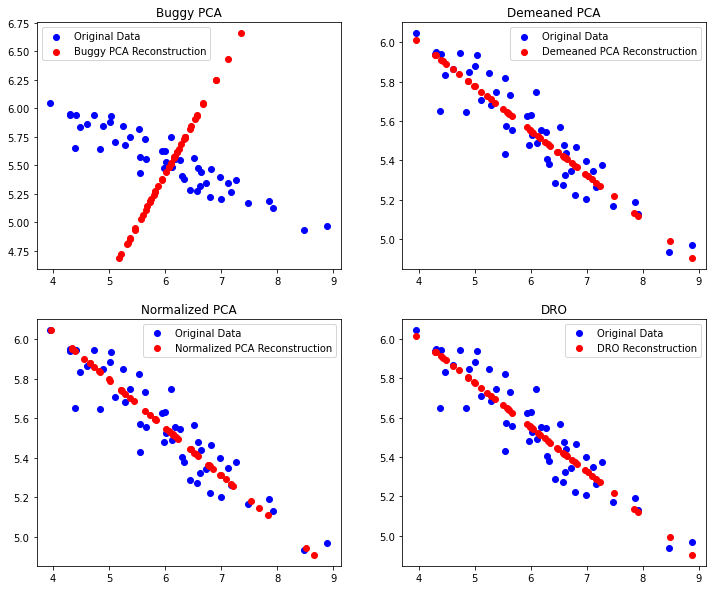

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd
data_2D = pd.read_csv('data2D.csv', header=None).values
data_1000D = pd.read_csv('data1000D.csv', header=None).values
def buggy_pca(X,d):
    U,S,Vt = np.linalg.svd(X, full_matrices=False) # SVD
    W = Vt.T[:,:d]
    Z=np.dot(X,W)
    X_recon = np.dot(Z, W.T)
    return Z, X_recon, None

def demeaned_pca(X,d):
    mean_X = np.mean(X,axis=0)
    X_centered = X - mean_X
    Z, X_recon,_ = buggy_pca(X_centered,d)
    X_recon += mean_X
    return Z, X_recon, mean_X
    
def normalized_pca(X,d):
    mean_X = np.mean(X,axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    Z, X_recon,_ = buggy_pca(X_normalized,d)
    X_recon = X_recon*std_X+mean_X
    return Z, X_recon, (mean_X, std_X)

def dro(X,d):
    mean_X = np.mean(X,axis=0)
    X_centered = X - mean_X
    U,S,Vt = np.linalg.svd(X_centered, full_matrices=False) # SVD
    W = Vt.T[:,:d]
    Z= np.dot(X_centered,W)
    X_recon = np.dot(Z,W.T)+mean_X
    return Z, X_recon,mean_X

def error(original_data, reconstructed_data):
    return (np.sum(np.square(original_data - reconstructed_data)))/len(original_data)

_,reconstructed_2D_buggy,_= buggy_pca(data_2D, 1)
_,reconstructed_2D_demeaned,_ = demeaned_pca(data_2D, 1)
_,reconstructed_2D_normalized,_= normalized_pca(data_2D, 1)
_,reconstructed_2D_dro,_= dro(data_2D, 1)

error_2D_buggy = error(data_2D, reconstructed_2D_buggy)
error_2D_demeaned = error(data_2D, reconstructed_2D_demeaned)
error_2D_normalized = error(data_2D, reconstructed_2D_normalized)
error_2D_dro = error(data_2D, reconstructed_2D_dro)
print(f'2D Dataset Reconstruction Errors:')
print(f'Buggy PCA: {error_2D_buggy}')
print(f'Demeaned PCA: {error_2D_demeaned}')
print(f'Normalized PCA: {error_2D_normalized}')
print(f'DRO: {error_2D_dro}')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(data_2D[:, 0], data_2D[:, 1], c='blue', label='Original Data')
axs[0, 0].scatter(reconstructed_2D_buggy[:, 0], reconstructed_2D_buggy[:, 1], c='red',label='Buggy PCA Reconstruction')
axs[0, 0].set_title('Buggy PCA')
axs[0, 0].legend() 

axs[0, 1].scatter(data_2D[:, 0], data_2D[:, 1], c='blue', label='Original Data')
axs[0, 1].scatter(reconstructed_2D_demeaned[:, 0], reconstructed_2D_demeaned[:, 1], c='red',label='Demeaned PCA Reconstruction')
axs[0, 1].set_title('Demeaned PCA')
axs[0, 1].legend() 

axs[1, 0].scatter(data_2D[:, 0], data_2D[:, 1], c='blue', label='Original Data')
axs[1, 0].scatter(reconstructed_2D_normalized[:, 0], reconstructed_2D_normalized[:, 1], c='red',label='Normalized PCA Reconstruction')
axs[1, 0].set_title('Normalized PCA')
axs[1, 0].legend() 

axs[1, 1].scatter(data_2D[:, 0], data_2D[:, 1], c='blue', label='Original Data')
axs[1, 1].scatter(reconstructed_2D_dro[:, 0], reconstructed_2D_dro[:, 1], c='red',label='DRO Reconstruction')
axs[1, 1].set_title('DRO')
axs[1, 1].legend() 

In [3]:
def find_singular_value(X):
    mean_X = np.mean(X,axis=0)
    X_centered = X - mean_X
    U,S,Vt = np.linalg.svd(X_centered, full_matrices=False) # SVD
    return S
singular_values = find_singular_value(data_1000D)
plt.figure()

plt.plot(singular_values, '*')
plt.title('Plot of Singular Values')
plt.xlabel('Dimension')
plt.ylabel('Singular Value')
plt.show()

In [4]:
d=30
_, reconstructed_1000D_buggy,_ = buggy_pca(data_1000D, d)
_, reconstructed_1000D_demeaned,_ = demeaned_pca(data_1000D, d)
_, reconstructed_1000D_normalized,_ = normalized_pca(data_1000D, d)
_, reconstructed_1000D_dro,_ = dro(data_1000D, d)

error_1000D_buggy = error(data_1000D, reconstructed_1000D_buggy)
error_1000D_demeaned = error(data_1000D, reconstructed_1000D_demeaned)
error_1000D_normalized = error(data_1000D, reconstructed_1000D_normalized)
error_1000D_dro = error(data_1000D, reconstructed_1000D_dro)

print(f'1000D Dataset Reconstruction Errors:')
print(f'Buggy PCA: {error_1000D_buggy}')
print(f'Demeaned PCA: {error_1000D_demeaned}')
print(f'Normalized PCA: {error_1000D_normalized}')
print(f'DRO: {error_1000D_dro}')

1000D Dataset Reconstruction Errors:
Buggy PCA: 802.7313986203584
Demeaned PCA: 273.04595897860275
Normalized PCA: 273.6285809976233
DRO: 273.04595897860275
